In [23]:
# Import the necessary libraries
import wordcloud
import nltk
import textblob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib_inline
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import unicodedata
from spellchecker import SpellChecker
import sklearn
import imblearn

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline
#import warnings
#warnings.simplefilter("ignore")


In [3]:
# Read in the file with the correct encoding
data = pd.read_csv('brandandproductemotions.csv', encoding='latin1')

# Display the first few rows of the data and rename colummns
data.columns = ['tweet', 'brand_og', 'target']

############## updated this to new scale for Textblob analysis
# rename target column values to simpler expressions
emotions = {'Negative emotion': 'negative','Positive emotion':'positive','No emotion toward brand or product':'neutral', 'I cant tell':'unknown'}
data['target'] = data['target'].map(emotions)
emotions = {'neutral':0, 'positive':1, 'negative':-1}
data['target'] = data['target'].map(emotions)

# Replace NaN with "unknown" in the 'brand_og' column
data['brand_og'].fillna('unknown', inplace=True)

# make all cells lower
data = data.applymap(lambda s: s.lower() if type(s) == str else s)

# key words to search for to ID brand
apple = ['iphone',
         'ipad',
         'itunes',
         'apple']
android = ['google',
           'samsung',
           'android']

##############
# Drop null in 'target' and 'tweet'
data = data.dropna(subset=['target', 'tweet'])



data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet     8936 non-null   object 
 1   brand_og  8936 non-null   object 
 2   target    8936 non-null   float64
dtypes: float64(1), object(2)
memory usage: 279.2+ KB


In [4]:
# function to create new brand column based on values in tweet
def check_substring(tweet):
    # check if any of the sub strings appear individually
    apple_list = any(substring in tweet for substring in apple)
    android_list = any(substring in tweet for substring in android)

    if apple_list and android_list:
        return "both"
    elif apple_list:
        return "apple"
    elif android_list:
        return "android"
    else:
        return "unknown"

data['new_brand'] = data['tweet'].apply(check_substring)

In [5]:
# Value counts for 'target'
#target_counts = data['target'].value_counts()
#print("Value counts for 'target':")
#print(target_counts)

# Value counts for 'analysis'
#analysis_counts = data['analysis'].value_counts()
#print("\nValue counts for 'analysis':")
#print(analysis_counts)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet      8936 non-null   object 
 1   brand_og   8936 non-null   object 
 2   target     8936 non-null   float64
 3   new_brand  8936 non-null   object 
dtypes: float64(1), object(3)
memory usage: 349.1+ KB


In [6]:
data['new_brand'].value_counts()

apple      5237
android    2727
unknown     716
both        256
Name: new_brand, dtype: int64

In [7]:
# drop android and unknown

#### LOOK AT REORDERING THIS IT DOESNT FLOW WELL RIGHT NOW
data_apple = data[~data['new_brand'].isin(['android', 'unknown'])]
print(data_apple.info())
print(data_apple['new_brand'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5493 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet      5493 non-null   object 
 1   brand_og   5493 non-null   object 
 2   target     5493 non-null   float64
 3   new_brand  5493 non-null   object 
dtypes: float64(1), object(3)
memory usage: 214.6+ KB
None
apple    5237
both      256
Name: new_brand, dtype: int64


In [8]:

# DONE - Text Standardization: Convert all the text to a standard format, typically lowercase, to ensure uniformity across the entire dataset.

# DONE - Tokenization: Break the text into individual words or tokens. You can use libraries like NLTK (Natural Language Toolkit) or SpaCy for tokenization.

# DONE of URLs: Since URLs do not provide useful information for NLP tasks, it's recommended to remove them. This can be achieved using regular expressions.

# DONE - Removing @ mentions and Hashtags: The "@" mentions and "#" hashtags can be removed using regular expressions. Alternatively, you may want to replace them with the appropriate words that they are signifying. This can vary based on the specifics of your project.

# DONE - Removing Emoji and Emoticons: These can either skew your model (since they may not be present in your training set) or they could be turned into standardized text. For example, :) can be converted to the word 'smile'. You can use an emoji library for this purpose.

# DONE - Removing Punctuation: Punctuation can be removed using regular expressions or string manipulation functions.

# DONE - Stopwords Removal: Words such as "is", "and", "the", etc., are often removed as they usually do not carry much useful information. Libraries like NLTK and SpaCy have built-in lists of stopwords that can be used.

# DONE - Removing Numbers: Depending on the context, you might want to remove numbers. You can do this using regular expressions.

# DONE - Stemming or Lemmatization: This process involves reducing a word to its root form. For example, "running" is reduced to "run". Stemming can be a crude process, but it's faster. Lemmatization is more accurate but computationally more intensive.

# Handling Negations: Certain negation phrases like "not good", "isn't", "wasn't" etc. should be handled carefully. You may want to treat them as one term ("not_good", "is_not", "was_not") so that the sentiment isn't lost.

# NOT DONE YET - Spell Checking: This is particularly important for tweets as they often contain misspelled words. You can use a library like pyspellchecker for this.

# DONE - Removing Extra Whitespaces: Finally, make sure that there are no additional whitespaces in your text.

# Keep in mind that not all these steps will be necessary for every NLP task, and some may even be counterproductive. For example, in sentiment analysis, removing emojis could potentially remove useful sentiment information. Similarly, if you're doing an authorship attribution task, you might want to keep features like capitalization, as they can be indicative of individual writing styles. Therefore, the steps should be tailored to the specifics of your NLP task.


In [9]:
def clean_tweet(text):
    # Remove hashtags (words starting with '#')
    text = re.sub(r'#\w+', '', text)
    
    # Handle RT tags
    text = re.sub(r'[Rr][Tt]', '', text)
    
    # Remove mentions (words starting with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        
    # Remove special characters and numbers not adjacent to text
    text = re.sub(r'\b\d+\b', '', text)

    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = [word for word in text.split() if word not in stop_words]

    # Unique words to remove, add more as needed
    words_to_remove = ['Austin', 'Link', 'Sxsw', 'sxsw']

    for word in words_to_remove:
        cleaned_text = [w for w in cleaned_text if not re.match(r'\b{}\b'.format(word), w, flags=re.IGNORECASE)]

    return ' '.join(cleaned_text)


In [10]:
data_apple['cleaned_tweet'] = data_apple['tweet'].apply(clean_tweet)
data_apple['cleaned_tweet'].head(15)

<ipython-input-10-57996181ac56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_apple['cleaned_tweet'] = data_apple['tweet'].apply(clean_tweet)


0     3g iphone hrs tweeting dead need upgrade plugi...
1     know awesome ipadiphone app youll likely appre...
2                                        wait also sale
3      hope years festival isnt crashy years iphone app
5      new ipad apps communication showcased conference
8            beautifully sma simple idea wrote ipad app
9     counting days plus strong canadian dollar mean...
14                                       great ipad app
15                          haha awesomely rad ipad app
16                holler gram ipad itunes app store via
17    noticed dst coming weekend many iphone users h...
18    added flights matching people planesairpos als...
19    must app lovely review forbes ipad app holler ...
20        need buy ipad2 im sure ill need q apple store
21    oh god app ipad pure unadulterated awesome eas...
Name: cleaned_tweet, dtype: object

In [11]:
type(data_apple['cleaned_tweet'][0])

str

In [12]:
def tokenized_tweet(text):
    # Tokenize the cleaned tweet
    tknzr = TweetTokenizer()
    tokenized_tweet = tknzr.tokenize(text)

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokenized_tweet = [lemmatizer.lemmatize(word) for word in tokenized_tweet]

    ##### takes an eternity to run
    # Apply optimized spell correction
    #tokenized_tweet = [optimized_spell_correction(word) for word in tokenized_tweet]

    return tokenized_tweet

In [13]:
data_apple['tokenized_tweet'] = data_apple['cleaned_tweet'].apply(lambda x: tokenized_tweet(x))
data_apple['tokenized_tweet'].head(15)



<ipython-input-13-079aa5cbfc21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_apple['tokenized_tweet'] = data_apple['cleaned_tweet'].apply(lambda x: tokenized_tweet(x))


0     [3g, iphone, hr, tweeting, dead, need, upgrade...
1     [know, awesome, ipadiphone, app, youll, likely...
2                                    [wait, also, sale]
3     [hope, year, festival, isnt, crashy, year, iph...
5     [new, ipad, apps, communication, showcased, co...
8     [beautifully, sma, simple, idea, wrote, ipad, ...
9     [counting, day, plus, strong, canadian, dollar...
14                                   [great, ipad, app]
15                    [haha, awesomely, rad, ipad, app]
16        [holler, gram, ipad, itunes, app, store, via]
17    [noticed, dst, coming, weekend, many, iphone, ...
18    [added, flight, matching, people, planesairpos...
19    [must, app, lovely, review, forbes, ipad, app,...
20    [need, buy, ipad, 2, im, sure, ill, need, q, a...
21    [oh, god, app, ipad, pure, unadulterated, awes...
Name: tokenized_tweet, dtype: object

In [14]:
data_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5493 entries, 0 to 9091
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet            5493 non-null   object 
 1   brand_og         5493 non-null   object 
 2   target           5493 non-null   float64
 3   new_brand        5493 non-null   object 
 4   cleaned_tweet    5493 non-null   object 
 5   tokenized_tweet  5493 non-null   object 
dtypes: float64(1), object(5)
memory usage: 460.4+ KB


In [15]:
# Creating function for calculating positive, negative and neutral
def ratio(x):
 if x > 0:
    return 1
 elif x == 0:
    return 0
 else:
    return -1

# Creating new column and rounding to one decimal for easier viewing
data_apple['polarity'] = data_apple['cleaned_tweet'].apply(lambda text: TextBlob(text).sentiment.polarity)
data_apple['analysis'] = data_apple['polarity'].apply(ratio)
data_apple['analysis'] = data_apple['analysis'].astype(float)
data_apple['analysis'] = data_apple['analysis'].round(3)

# Value counts for 'target'
target_counts = data_apple['target'].value_counts()

# Value counts for 'analysis'
analysis_counts = data_apple['analysis'].value_counts()

print("Value counts for 'target':")
print(target_counts)

print("\nValue counts for 'analysis':")
print(analysis_counts)

Value counts for 'target':
 0.0    2929
 1.0    2144
-1.0     420
Name: target, dtype: int64

Value counts for 'analysis':
 1.0    2466
 0.0    2464
-1.0     563
Name: analysis, dtype: int64


<ipython-input-15-a7674c79de06>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_apple['polarity'] = data_apple['cleaned_tweet'].apply(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-15-a7674c79de06>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_apple['analysis'] = data_apple['polarity'].apply(ratio)
<ipython-input-15-a7674c79de06>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [16]:
# focusing on negative and positive tweets only for first iteration of the model
data_apple.loc[(data_apple['target'] == 0) & (data_apple['analysis'] == -1), 'target'] = data_apple['analysis']

# Value counts for 'target'
target_counts = data_apple['target'].value_counts()

# Value counts for 'analysis'
analysis_counts = data_apple['analysis'].value_counts()

print("Value counts for 'target':")
print(target_counts)

print("\nValue counts for 'analysis':")
print(analysis_counts)

Value counts for 'target':
 0.0    2647
 1.0    2144
-1.0     702
Name: target, dtype: int64

Value counts for 'analysis':
 1.0    2466
 0.0    2464
-1.0     563
Name: analysis, dtype: int64


c:\Users\sean8\Anaconda3 Software\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
# drop nuetral sentiment to focus on positive and negative sentiment for this itteration
data_apple = data_apple.drop(data_apple[data_apple['target'] == 0.0].index)

# Value counts for 'target'
target_counts = data_apple['target'].value_counts()

# Value counts for 'analysis'
analysis_counts = data_apple['analysis'].value_counts()

print("Value counts for 'target':")
print(target_counts)
print("Negative sentiment is 24.5% of the data")

Value counts for 'target':
 1.0    2144
-1.0     702
Name: target, dtype: int64
Negative sentiment is 24.5% of the data


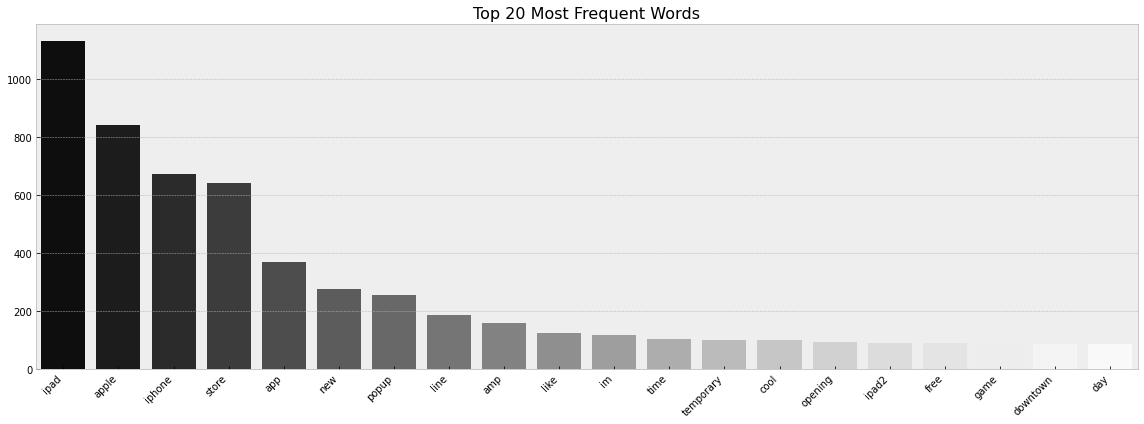

In [18]:
# Convert tokenized tweets back to strings
data_apple['cleaned_tweet_str'] = data_apple['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))
data_apple['cleaned_tweet_str'].astype(str)

# Initialize CountVectorizer with stop_words
cv = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_counts = cv.fit_transform(data_apple['cleaned_tweet'])

# Rest of the code remains the same
# Get the word frequencies
sum_words = X_counts.sum(axis=0)
# Create a list of (word, frequency) tuples
frequencies = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
# Sort the frequencies in descending order
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
# Convert the list to a DataFrame
df_frequencies = pd.DataFrame(frequencies, columns=['word', 'frequency'])

# Plot the top 20 most frequent words
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='word', y='frequency', data=df_frequencies.head(20), palette='Greys_r')
ax.set_title('Top 20 Most Frequent Words', fontsize=16)
ax.set(xlabel=None, ylabel=None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
data_apple.info()
#### How is it all back...I'm too tired

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2846 entries, 0 to 9091
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet              2846 non-null   object 
 1   brand_og           2846 non-null   object 
 2   target             2846 non-null   float64
 3   new_brand          2846 non-null   object 
 4   cleaned_tweet      2846 non-null   object 
 5   tokenized_tweet    2846 non-null   object 
 6   polarity           2846 non-null   float64
 7   analysis           2846 non-null   float64
 8   cleaned_tweet_str  2846 non-null   object 
dtypes: float64(3), object(6)
memory usage: 222.3+ KB


In [40]:
# dropping columns before creating new csv file called modified_data_apple.csv
df_csv = data_apple.drop(columns=['tweet', 'brand_og', 'polarity', 'analysis'])
df_csv.to_csv('modified_data_apple.csv', index=False)


In [38]:
df_csv.isna().sum().sum()

0

In [31]:
X = data_apple['cleaned_tweet']
y = data_apple['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [32]:
from collections import Counter

# Determine the class counts
class_counts = Counter(y_train)
majority_count = class_counts[1]
minority_count = class_counts[-1]

print("Class counts: ", class_counts)
print('Majority Count: ', majority_count)
print('Minority Count: ', minority_count)

Class counts:  Counter({1.0: 1726, -1.0: 550})
Majority Count:  1726
Minority Count:  550


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

###trying to simplify the sampling to stop errors
### to see both smote and undersampling look at the next cell

# Transforming the text data into numerical form
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Applying SMOTE 
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)





AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
# smote and under sampling
from collections import Counter

# Determine the class counts
class_counts = Counter(y_train)
majority_count = class_counts[1]
minority_count = class_counts[-1]

# Target minority count to achieve 30% ratio after SMOTEENN
target_minority_count_smoteenn = int(0.3 * (majority_count + minority_count) / 0.7)

# Target majority count to achieve 40% ratio for minority after RandomUnderSampler
target_majority_count_undersample = int(target_minority_count_smoteenn / 0.4 * 0.6)

# Transforming the text data into numerical form
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Applying SMOTEENN
smote_enn = SMOTEENN(sampling_strategy={-1: target_minority_count_smoteenn, 1: majority_count})
X_resampled, y_resampled = smote_enn.fit_resample(X_train_tfidf, y_train)

# Applying RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy={-1: target_minority_count_smoteenn, 1: target_majority_count_undersample})
X_resampled, y_resampled = under_sampler.fit_resample(X_resampled, y_resampled)


In [35]:
# Determine the class counts
class_counts = Counter(y_resampled)
majority_count = class_counts[1]
minority_count = class_counts[-1]

print("Class counts: ", class_counts)
print('Majority Count: ', majority_count)
print('Minority Count: ', minority_count)

NameError: name 'y_resampled' is not defined